# Big Data Clustering Final Project

- Name : Abidjanna Zulfa Hamdika
- Student ID : 5025201197
- Class : Big Data A

# Setting Up PySpark Environment

In [1]:
# set up Java Dev Kit and download Spark and Hadoop
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://downloads.apache.org/spark/spark-3.2.4/spark-3.2.4-bin-hadoop3.2.tgz

# unpack Spark and Hadoop
!tar xf spark-3.2.4-bin-hadoop3.2.tgz

# set up home paths for Java and Spark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.4-bin-hadoop3.2"

--2023-06-15 16:00:26--  https://downloads.apache.org/spark/spark-3.2.4/spark-3.2.4-bin-hadoop3.2.tgz
Resolving downloads.apache.org (downloads.apache.org)... 88.99.95.219, 135.181.214.104, 2a01:4f9:3a:2c57::2, ...
Connecting to downloads.apache.org (downloads.apache.org)|88.99.95.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 301183180 (287M) [application/x-gzip]
Saving to: ‘spark-3.2.4-bin-hadoop3.2.tgz’

spark-3.2.4-bin-had 100%[===================>] 287.23M  19.4MB/s    in 15s     

2023-06-15 16:00:42 (18.6 MB/s) - ‘spark-3.2.4-bin-hadoop3.2.tgz’ saved [301183180/301183180]



In [2]:
# install, import and initialise findspark
!pip install -q findspark
import findspark
findspark.init()

# set up spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

# Data Loading

In [3]:
from pyspark.sql.functions import when, count, isnull, isnan, col
from functools import reduce

In [4]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# Download dataset from kaggle link

import opendatasets as od
od.download("https://www.kaggle.com/datasets/russellyates88/suicide-rates-overview-1985-to-2016")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: marvesco
Your Kaggle Key: ··········


100%|██████████| 397k/397k [00:00<00:00, 52.0MB/s]

In [61]:
# Read dataset as csv
df = spark.read.csv('suicide-rates-overview-1985-to-2016/master.csv', header=True, inferSchema=True)

In [62]:
df.show()

+-------+----+------+-----------+-----------+----------+-----------------+------------+------------+------------------+------------------+---------------+
|country|year|   sex|        age|suicides_no|population|suicides/100k pop|country-year|HDI for year| gdp_for_year ($) |gdp_per_capita ($)|     generation|
+-------+----+------+-----------+-----------+----------+-----------------+------------+------------+------------------+------------------+---------------+
|Albania|1987|  male|15-24 years|         21|    312900|             6.71| Albania1987|        null|     2,156,624,900|               796|   Generation X|
|Albania|1987|  male|35-54 years|         16|    308000|             5.19| Albania1987|        null|     2,156,624,900|               796|         Silent|
|Albania|1987|female|15-24 years|         14|    289700|             4.83| Albania1987|        null|     2,156,624,900|               796|   Generation X|
|Albania|1987|  male|  75+ years|          1|     21800|             4

In [8]:
df.printSchema()

root
 |-- country: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: string (nullable = true)
 |-- suicides_no: integer (nullable = true)
 |-- population: integer (nullable = true)
 |-- suicides/100k pop: double (nullable = true)
 |-- country-year: string (nullable = true)
 |-- HDI for year: double (nullable = true)
 |--  gdp_for_year ($) : string (nullable = true)
 |-- gdp_per_capita ($): integer (nullable = true)
 |-- generation: string (nullable = true)



In [9]:
# Check dataset shape
print(f"Shape: ({df.count()}, {len(df.columns)})")

Shape: (27820, 12)


In [10]:
df_rows = df.collect()
df_rows[0]['country']

'Albania'

# Data Preprocessing

In [63]:
from functools import reduce
from pyspark.sql.types import DoubleType
from pyspark.sql.types import IntegerType

# Renaming dataset so that it don't use a special characters
oldColumns = [" gdp_for_year ($) ", "gdp_per_capita ($)"]
newColumns = ["gdp_per_year", "gdp_per_capita"]

df = reduce(lambda df, idx: df.withColumnRenamed(oldColumns[idx], newColumns[idx]), range(len(oldColumns)), df)
df.printSchema()
df.show()

root
 |-- country: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: string (nullable = true)
 |-- suicides_no: integer (nullable = true)
 |-- population: integer (nullable = true)
 |-- suicides/100k pop: double (nullable = true)
 |-- country-year: string (nullable = true)
 |-- HDI for year: double (nullable = true)
 |-- gdp_per_year: string (nullable = true)
 |-- gdp_per_capita: integer (nullable = true)
 |-- generation: string (nullable = true)

+-------+----+------+-----------+-----------+----------+-----------------+------------+------------+-------------+--------------+---------------+
|country|year|   sex|        age|suicides_no|population|suicides/100k pop|country-year|HDI for year| gdp_per_year|gdp_per_capita|     generation|
+-------+----+------+-----------+-----------+----------+-----------------+------------+------------+-------------+--------------+---------------+
|Albania|1987|  male|15-24 years|         21|    3129

In [64]:
cols = df.columns

# show count of when the column is null for each of those columns
df.select([count(when(isnull(c), c)).alias(c) for c in cols]).show()

+-------+----+---+---+-----------+----------+-----------------+------------+------------+------------+--------------+----------+
|country|year|sex|age|suicides_no|population|suicides/100k pop|country-year|HDI for year|gdp_per_year|gdp_per_capita|generation|
+-------+----+---+---+-----------+----------+-----------------+------------+------------+------------+--------------+----------+
|      0|   0|  0|  0|          0|         0|                0|           0|       19456|           0|             0|         0|
+-------+----+---+---+-----------+----------+-----------------+------------+------------+------------+--------------+----------+



In [65]:
# get HDI per year for each country
df_rows = df.collect()
hdi_percountry = {}
for row in df_rows:
    if row['country'] not in hdi_percountry and row['HDI for year'] != None:
        hdi_percountry[row['country']] = row['HDI for year']
hdi_percountry

{'Albania': 0.619,
 'Antigua and Barbuda': 0.781,
 'Argentina': 0.694,
 'Armenia': 0.632,
 'Australia': 0.865,
 'Austria': 0.764,
 'Azerbaijan': 0.609,
 'Bahamas': 0.778,
 'Bahrain': 0.727,
 'Barbados': 0.7,
 'Belarus': 0.683,
 'Belgium': 0.774,
 'Belize': 0.644,
 'Bosnia and Herzegovina': 0.724,
 'Brazil': 0.576,
 'Bulgaria': 0.686,
 'Canada': 0.827,
 'Chile': 0.654,
 'Colombia': 0.573,
 'Costa Rica': 0.623,
 'Croatia': 0.694,
 'Cuba': 0.653,
 'Cyprus': 0.8,
 'Czech Republic': 0.761,
 'Denmark': 0.83,
 'Ecuador': 0.631,
 'El Salvador': 0.522,
 'Estonia': 0.719,
 'Fiji': 0.694,
 'Finland': 0.783,
 'France': 0.741,
 'Georgia': 0.672,
 'Germany': 0.801,
 'Greece': 0.741,
 'Grenada': 0.737,
 'Guatemala': 0.483,
 'Guyana': 0.542,
 'Hungary': 0.74,
 'Iceland': 0.776,
 'Ireland': 0.742,
 'Israel': 0.768,
 'Italy': 0.738,
 'Jamaica': 0.65,
 'Japan': 0.791,
 'Kazakhstan': 0.69,
 'Kuwait': 0.732,
 'Kyrgyzstan': 0.615,
 'Latvia': 0.67,
 'Lithuania': 0.701,
 'Luxembourg': 0.752,
 'Maldives': 0.60

In [66]:
# Copy the schema of your Spark dataframe
import numpy as np

schema = df.schema

# Create Pandas Dataframe using your Spark DataFrame
pandas_df = df.toPandas()


# Function to remove comma from gdp_per_year so that it can be casted as Integer
import re
def remove_comma(input_string):
    return re.sub(',', '', input_string)

# Assigning HDI for year value for each country
for ind in pandas_df.index:
    if np.isnan(pandas_df.loc[ind, 'HDI for year']):
        if pandas_df.loc[ind, 'country'] in hdi_percountry:
            pandas_df.loc[ind,'HDI for year'] = hdi_percountry[pandas_df.loc[ind, 'country']]

    # Assigning function to remove comma
    pandas_df.loc[ind, 'gdp_per_year'] = remove_comma(pandas_df.loc[ind, 'gdp_per_year'])

for ind in pandas_df.index:
    if np.isnan(pandas_df.loc[ind, 'HDI for year']):
        pandas_df.loc[ind, 'HDI for year'] = pandas_df['HDI for year'].mean()


# Update your dataframe with the new value using the Pandas DataFrame
df = spark.createDataFrame(pandas_df,schema=schema)

# Delete the auxiliary pandas dataframe to free memory for other use
del pandas_df
del df_rows

df.show()

+-------+----+------+-----------+-----------+----------+-----------------+------------+------------+------------+--------------+---------------+
|country|year|   sex|        age|suicides_no|population|suicides/100k pop|country-year|HDI for year|gdp_per_year|gdp_per_capita|     generation|
+-------+----+------+-----------+-----------+----------+-----------------+------------+------------+------------+--------------+---------------+
|Albania|1987|  male|15-24 years|         21|    312900|             6.71| Albania1987|       0.619|  2156624900|           796|   Generation X|
|Albania|1987|  male|35-54 years|         16|    308000|             5.19| Albania1987|       0.619|  2156624900|           796|         Silent|
|Albania|1987|female|15-24 years|         14|    289700|             4.83| Albania1987|       0.619|  2156624900|           796|   Generation X|
|Albania|1987|  male|  75+ years|          1|     21800|             4.59| Albania1987|       0.619|  2156624900|           796|G.

## Feature Selections

In [16]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.stat import Correlation
import pandas as pd

# Select the real numeric values (not categorical) for correlation heatmap
corr_cols  = ['suicides_no', 'population', 'suicides/100k pop']
assembler = VectorAssembler(inputCols=corr_cols, outputCol='corr_features')
df_vector = assembler.transform(df).select('corr_features')

# Creating the heatmap
matrix = Correlation.corr(df_vector, 'corr_features').collect()[0][0]
corr_matrix = matrix.toArray().tolist()
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns=corr_cols, index=corr_cols)
corr_matrix_df.style.background_gradient().set_precision(2)

/content/spark-3.2.4-bin-hadoop3.2/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
<ipython-input-16-3e0683069b09>:14: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr_matrix_df.style.background_gradient().set_precision(2)


,suicides_no,population,suicides/100k pop
suicides_no,1.00,0.62,0.31
population,0.62,1.00,0.01
suicides/100k pop,0.31,0.01,1.00


## Feature Scaling

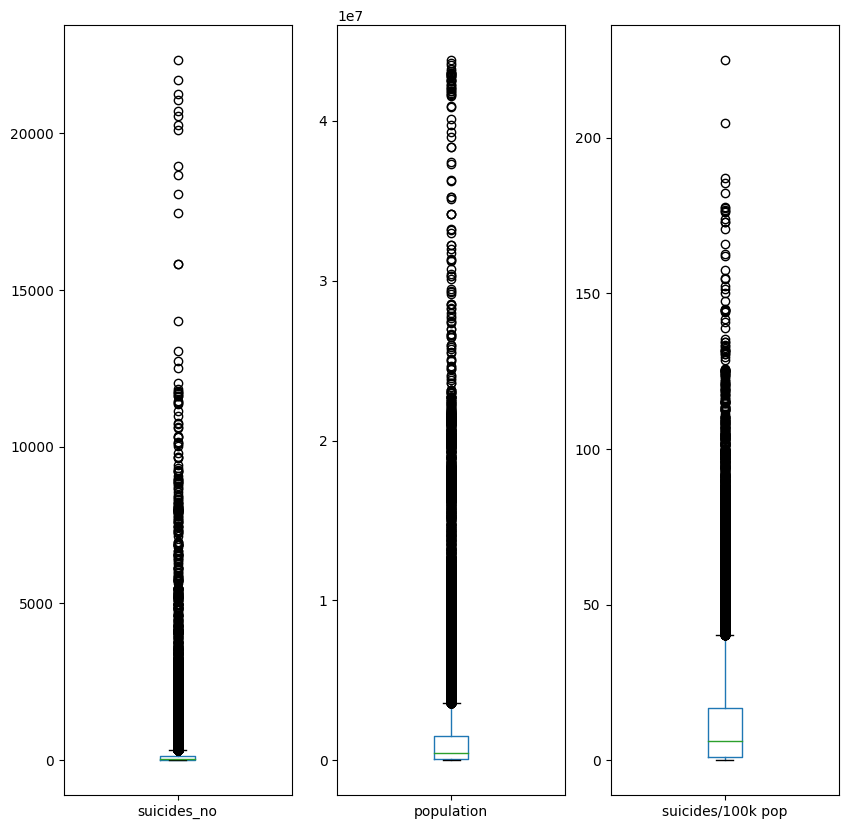

In [17]:
# Checking for outliers in the numeric columns

pandas_df = df.toPandas()

import matplotlib.pyplot as plt
plot_cols = ['suicides_no', 'population', 'suicides/100k pop']

plt.figure(figsize=(10, 10))
for i in range(1, 4):
    plt.subplot(1, 3, i)
    pandas_df.boxplot(column=plot_cols[i-1], grid=False)

del pandas_df

# Result tells us that the outliers is just to much, probably best if we didn't handle the outliers

In [18]:
# Create encoding
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# Encoding that the order matters
cat_columns = ['age', 'HDI for year', 'gdp_per_year', 'gdp_per_capita']

# Encoding that the order doesn't matter
one_hot_columns = ['country', 'year', 'sex', 'country-year', 'generation']

df_encoding = df

for column in df_encoding.columns:
    if column in cat_columns or column in one_hot_columns:
        indexer = StringIndexer(inputCol=column, outputCol=f'{column}-numeric')
        indexer_fitted = indexer.fit(df_encoding)
        df_encoding = indexer_fitted.transform(df_encoding)

    if column in one_hot_columns:
        encoder = OneHotEncoder(inputCol=f'{column}-numeric', outputCol=f'{column}-onehot')
        df_encoding_onehot = encoder.fit(df_encoding)
        df_encoding = df_encoding_onehot.transform(df_encoding)

df_encoding.show()

+-------+----+------+-----------+-----------+----------+-----------------+------------+------------+------------+--------------+---------------+---------------+----------------+------------+---------------+-----------+-------------+-----------+--------------------+-------------------+--------------------+--------------------+----------------------+------------------+-----------------+
|country|year|   sex|        age|suicides_no|population|suicides/100k pop|country-year|HDI for year|gdp_per_year|gdp_per_capita|     generation|country-numeric|  country-onehot|year-numeric|    year-onehot|sex-numeric|   sex-onehot|age-numeric|country-year-numeric|country-year-onehot|HDI for year-numeric|gdp_per_year-numeric|gdp_per_capita-numeric|generation-numeric|generation-onehot|
+-------+----+------+-----------+-----------+----------+-----------------+------------+------------+------------+--------------+---------------+---------------+----------------+------------+---------------+-----------+------

In [19]:
# Check that all rows were sucessfully encoded

df_pandas = df_encoding.toPandas()
print(len(df_pandas['country'].unique()))
print(len(df_pandas['country-numeric'].unique()))
print(len(df_pandas['country-onehot'].unique()))
del df_pandas

101
101
101


In [20]:
df_encoding.printSchema()

root
 |-- country: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: string (nullable = true)
 |-- suicides_no: integer (nullable = true)
 |-- population: integer (nullable = true)
 |-- suicides/100k pop: double (nullable = true)
 |-- country-year: string (nullable = true)
 |-- HDI for year: double (nullable = true)
 |-- gdp_per_year: string (nullable = true)
 |-- gdp_per_capita: integer (nullable = true)
 |-- generation: string (nullable = true)
 |-- country-numeric: double (nullable = false)
 |-- country-onehot: vector (nullable = true)
 |-- year-numeric: double (nullable = false)
 |-- year-onehot: vector (nullable = true)
 |-- sex-numeric: double (nullable = false)
 |-- sex-onehot: vector (nullable = true)
 |-- age-numeric: double (nullable = false)
 |-- country-year-numeric: double (nullable = false)
 |-- country-year-onehot: vector (nullable = true)
 |-- HDI for year-numeric: double (nullable = false)
 |-- gdp_per_year-numer

In [21]:
# Select columns for scaling

selected_cols = ['suicides_no', 'population', 'suicides/100k pop']
for column in df_encoding.columns:
    if column in cat_columns:
        selected_cols.append(f'{column}-numeric')

    if column in one_hot_columns:
        selected_cols.append(f'{column}-onehot')
selected_cols

['suicides_no',
 'population',
 'suicides/100k pop',
 'country-onehot',
 'year-onehot',
 'sex-onehot',
 'age-numeric',
 'country-year-onehot',
 'HDI for year-numeric',
 'gdp_per_year-numeric',
 'gdp_per_capita-numeric',
 'generation-onehot']

In [22]:
df_selected = df_encoding.select(selected_cols)
df_selected.printSchema()
df_selected.show()

root
 |-- suicides_no: integer (nullable = true)
 |-- population: integer (nullable = true)
 |-- suicides/100k pop: double (nullable = true)
 |-- country-onehot: vector (nullable = true)
 |-- year-onehot: vector (nullable = true)
 |-- sex-onehot: vector (nullable = true)
 |-- age-numeric: double (nullable = false)
 |-- country-year-onehot: vector (nullable = true)
 |-- HDI for year-numeric: double (nullable = false)
 |-- gdp_per_year-numeric: double (nullable = false)
 |-- gdp_per_capita-numeric: double (nullable = false)
 |-- generation-onehot: vector (nullable = true)

+-----------+----------+-----------------+----------------+---------------+-------------+-----------+-------------------+--------------------+--------------------+----------------------+-----------------+
|suicides_no|population|suicides/100k pop|  country-onehot|    year-onehot|   sex-onehot|age-numeric|country-year-onehot|HDI for year-numeric|gdp_per_year-numeric|gdp_per_capita-numeric|generation-onehot|
+-----------

In [23]:
# alias all columns
cols = df_selected.columns

# show count of when the column is null for each of those columns
df_selected.select([count(when(isnull(c), c)).alias(c) for c in cols]).show()

+-----------+----------+-----------------+--------------+-----------+----------+-----------+-------------------+--------------------+--------------------+----------------------+-----------------+
|suicides_no|population|suicides/100k pop|country-onehot|year-onehot|sex-onehot|age-numeric|country-year-onehot|HDI for year-numeric|gdp_per_year-numeric|gdp_per_capita-numeric|generation-onehot|
+-----------+----------+-----------------+--------------+-----------+----------+-----------+-------------------+--------------------+--------------------+----------------------+-----------------+
|          0|         0|                0|             0|          0|         0|          0|                  0|                   0|                   0|                     0|                0|
+-----------+----------+-----------------+--------------+-----------+----------+-----------+-------------------+--------------------+--------------------+----------------------+-----------------+



In [24]:
scale_cols = selected_cols

In [25]:
df_preprocessed = df_selected.select(scale_cols)
df_preprocessed.show()

+-----------+----------+-----------------+----------------+---------------+-------------+-----------+-------------------+--------------------+--------------------+----------------------+-----------------+
|suicides_no|population|suicides/100k pop|  country-onehot|    year-onehot|   sex-onehot|age-numeric|country-year-onehot|HDI for year-numeric|gdp_per_year-numeric|gdp_per_capita-numeric|generation-onehot|
+-----------+----------+-----------------+----------------+---------------+-------------+-----------+-------------------+--------------------+--------------------+----------------------+-----------------+
|         21|    312900|             6.71|(100,[63],[1.0])|(31,[26],[1.0])|    (1,[],[])|        0.0|   (2320,[0],[1.0])|                39.0|               773.0|                2035.0|    (5,[0],[1.0])|
|         16|    308000|             5.19|(100,[63],[1.0])|(31,[26],[1.0])|    (1,[],[])|        2.0|   (2320,[0],[1.0])|                39.0|               773.0|                2

In [26]:
vecAssembler = VectorAssembler(inputCols=scale_cols, outputCol="features")
df_preprocessed = vecAssembler.transform(df_preprocessed)

# Scale features using StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scalerModel = scaler.fit(df_preprocessed)
df_preprocessed = scalerModel.transform(df_preprocessed)


In [27]:
# Renamed the column so that it can be used easily with K-Means
df_scaled = df_preprocessed.select('scaled_features')

oldColumns = ["scaled_features"]
newColumns = ["features"]

df_scaled = reduce(lambda df_scaled, idx: df_scaled.withColumnRenamed(oldColumns[idx], newColumns[idx]), range(len(oldColumns)), df_scaled)
df_scaled.printSchema()
df_scaled.show()

root
 |-- features: vector (nullable = true)

+--------------------+
|            features|
+--------------------+
|[-0.2456348523915...|
|[-0.2511777951850...|
|[-0.2533949723024...|
|[-0.2678066235654...|
|[-0.2589379150959...|
|[-0.2678066235654...|
|[-0.2622636807720...|
|[-0.2644808578894...|
|[-0.2678066235654...|
|[-0.2689152121241...|
|[-0.2689152121241...|
|[-0.2689152121241...|
|[-0.2666980350068...|
|[-0.2500692066263...|
|[-0.2678066235654...|
|[-0.2533949723024...|
|[-0.2644808578894...|
|[-0.2600465036546...|
|[-0.2655894464481...|
|[-0.2633722693307...|
+--------------------+
only showing top 20 rows



# Modelling & Evaluation

## K-Means

In [28]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator


### Silhouette_scores

In [29]:
# Evaluating K-Means Parameter with Silhouette Scores

silhouette_scores = []
clusters = []
for i in range(2, 11):
    kmeans = KMeans(k=i, seed=0)
    model = kmeans.fit(df_scaled)
    predictions = model.transform(df_scaled)

    evaluator = ClusteringEvaluator()
    silhouette_score = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette_score)
    clusters.append(i)

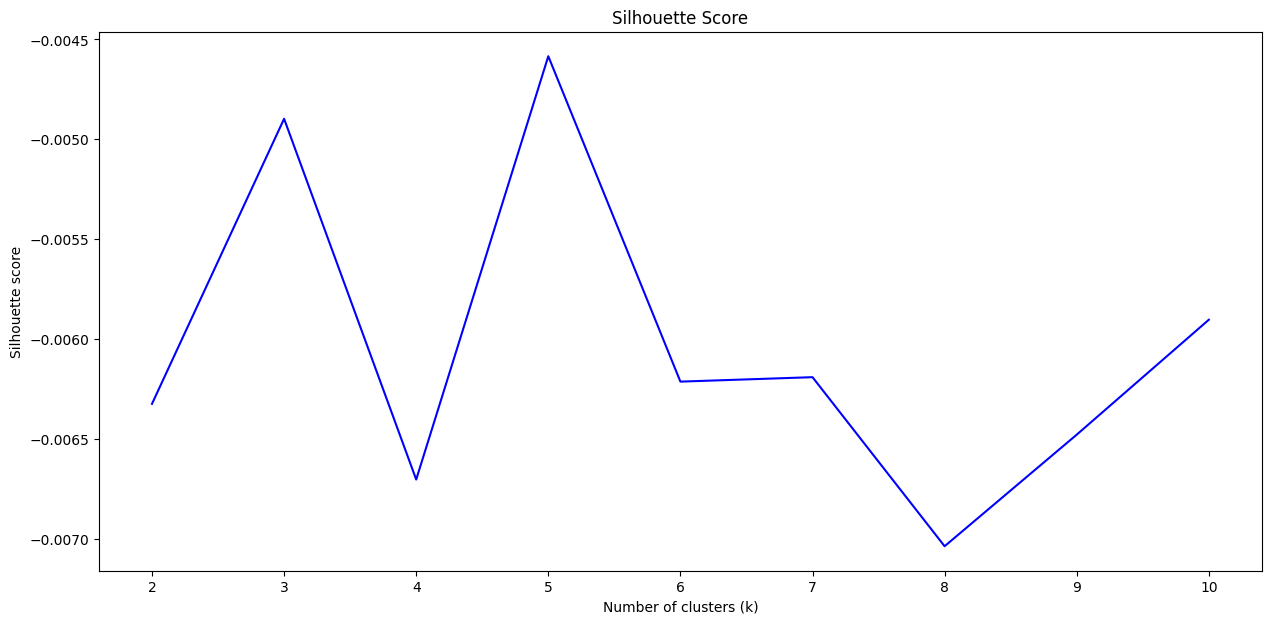

In [30]:
# Plotting Silhouette Scores for each clusters

plt.figure(figsize=(15,7))
plt.plot(clusters, silhouette_scores, color='blue')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette score')
plt.show()

### Elbow Method

In [31]:
# Evaluating K-Means Parameter with Elbow Method

elbow_scores = []
for i in clusters:
    kmeans = KMeans(k=i, seed=0)
    model = kmeans.fit(df_scaled)
    elbow_score = model.summary.trainingCost
    elbow_scores.append(elbow_score)

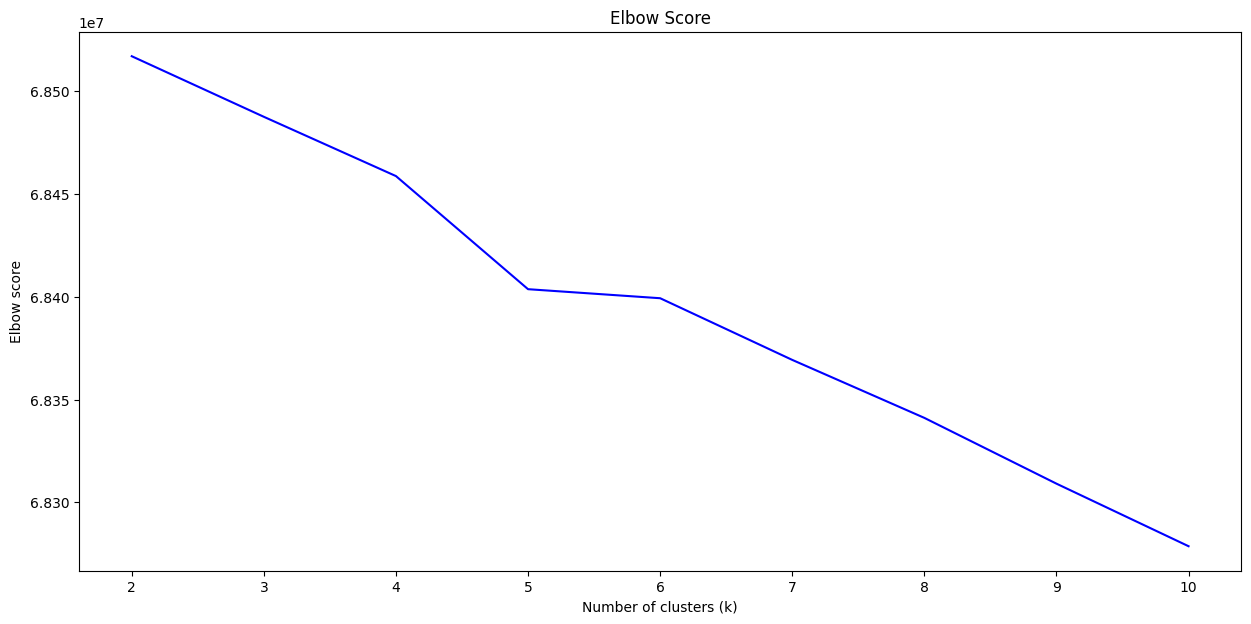

In [32]:
# Plotting Elbow Method Scores for each clusters

plt.figure(figsize=(15,7))
plt.plot(clusters, elbow_scores, color='blue')
plt.title('Elbow Score')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Elbow score')
plt.show()

In [33]:
# Based on those two methods
optimal_clusters = 5

### Dimensionality Reduction with PCA for better visualization

In [34]:
from pyspark.ml.feature import PCA

# Create a PCA instance to reduce dimensionality to 2 dimensions
pca = PCA(k=2, inputCol="features", outputCol="pca")

# Fit the PCA model to the data
pca_model = pca.fit(df_scaled)
pca_df = pca_model.transform(df_scaled).select("pca")

In [35]:
# Using K-Means with PCA input

kmeans = KMeans(k=optimal_clusters, seed=0, featuresCol="pca")
final_model = kmeans.fit(pca_df)
df_pca = final_model.transform(pca_df)
df_pca.show()

+--------------------+----------+
|                 pca|prediction|
+--------------------+----------+
|[0.68874015671827...|         0|
|[0.79114366288979...|         0|
|[0.79783283260468...|         0|
|[0.83334319245027...|         0|
|[0.61755461595798...|         0|
|[0.93384776520535...|         0|
|[0.91030041752712...|         0|
|[0.72385699314848...|         0|
|[0.82676189286438...|         0|
|[0.92675659355913...|         0|
|[0.92141371409420...|         0|
|[0.83325775882949...|         0|
|[0.85686287613159...|         0|
|[0.64108926443707...|         0|
|[0.77588688140130...|         0|
|[0.73814990357248...|         0|
|[0.75242147095482...|         0|
|[0.75621353873891...|         0|
|[0.84766190999810...|         0|
|[0.66220809787896...|         0|
+--------------------+----------+
only showing top 20 rows



In [36]:
df_pca.show()

+--------------------+----------+
|                 pca|prediction|
+--------------------+----------+
|[0.68874015671827...|         0|
|[0.79114366288979...|         0|
|[0.79783283260468...|         0|
|[0.83334319245027...|         0|
|[0.61755461595798...|         0|
|[0.93384776520535...|         0|
|[0.91030041752712...|         0|
|[0.72385699314848...|         0|
|[0.82676189286438...|         0|
|[0.92675659355913...|         0|
|[0.92141371409420...|         0|
|[0.83325775882949...|         0|
|[0.85686287613159...|         0|
|[0.64108926443707...|         0|
|[0.77588688140130...|         0|
|[0.73814990357248...|         0|
|[0.75242147095482...|         0|
|[0.75621353873891...|         0|
|[0.84766190999810...|         0|
|[0.66220809787896...|         0|
+--------------------+----------+
only showing top 20 rows



In [50]:
# Renaming dataset so that it don't use a special characters
oldColumns = ["prediction"]
newColumns = ["cluster"]

df_pca = reduce(lambda df_pca, idx: df_pca.withColumnRenamed(oldColumns[idx], newColumns[idx]), range(len(oldColumns)), df_pca)
df_pca.printSchema()
df_pca.show()

root
 |-- pca: vector (nullable = true)
 |-- cluster: integer (nullable = false)

+--------------------+-------+
|                 pca|cluster|
+--------------------+-------+
|[0.68874015671827...|      0|
|[0.79114366288979...|      0|
|[0.79783283260468...|      0|
|[0.83334319245027...|      0|
|[0.61755461595798...|      0|
|[0.93384776520535...|      0|
|[0.91030041752712...|      0|
|[0.72385699314848...|      0|
|[0.82676189286438...|      0|
|[0.92675659355913...|      0|
|[0.92141371409420...|      0|
|[0.83325775882949...|      0|
|[0.85686287613159...|      0|
|[0.64108926443707...|      0|
|[0.77588688140130...|      0|
|[0.73814990357248...|      0|
|[0.75242147095482...|      0|
|[0.75621353873891...|      0|
|[0.84766190999810...|      0|
|[0.66220809787896...|      0|
+--------------------+-------+
only showing top 20 rows



In [60]:
df.show()

+-------+----+------+-----------+-----------+----------+-----------------+------------+------------+------------+--------------+---------------+
|country|year|   sex|        age|suicides_no|population|suicides/100k pop|country-year|HDI for year|gdp_per_year|gdp_per_capita|     generation|
+-------+----+------+-----------+-----------+----------+-----------------+------------+------------+------------+--------------+---------------+
|Albania|1987|  male|15-24 years|         21|    312900|             6.71| Albania1987|       0.619|  2156624900|           796|   Generation X|
|Albania|1987|  male|35-54 years|         16|    308000|             5.19| Albania1987|       0.619|  2156624900|           796|         Silent|
|Albania|1987|female|15-24 years|         14|    289700|             4.83| Albania1987|       0.619|  2156624900|           796|   Generation X|
|Albania|1987|  male|  75+ years|          1|     21800|             4.59| Albania1987|       0.619|  2156624900|           796|G.

In [38]:
print(f"Shape: ({df.count()}, {len(df.columns)})")

Shape: (27820, 12)


In [39]:
print(f"Shape: ({df_pca.count()}, {len(df_pca.columns)})")

Shape: (27820, 2)


In [40]:
del df_scaled
del df_encoding
del df_preprocessed
del pca_df
del df_selected

# Visualizing the Result

### Cluster Visualization based on the Number of Suicides and Population

In [ ]:
import seaborn as sns


In [76]:
pandas_df = df.select('suicides_no', 'population').toPandas()
pandas_df

,suicides_no,population
0,21,312900
1,16,308000
2,14,289700
3,1,21800
4,9,274300
...,...,...
27815,107,3620833
27816,9,348465
27817,60,2762158
27818,44,2631600


In [77]:
pandas_df['cluster'] = df_pca.select('cluster').toPandas()
pandas_df

,suicides_no,population,cluster
0,21,312900,0
1,16,308000,0
2,14,289700,0
3,1,21800,0
4,9,274300,0
...,...,...,...
27815,107,3620833,3
27816,9,348465,3
27817,60,2762158,3
27818,44,2631600,3


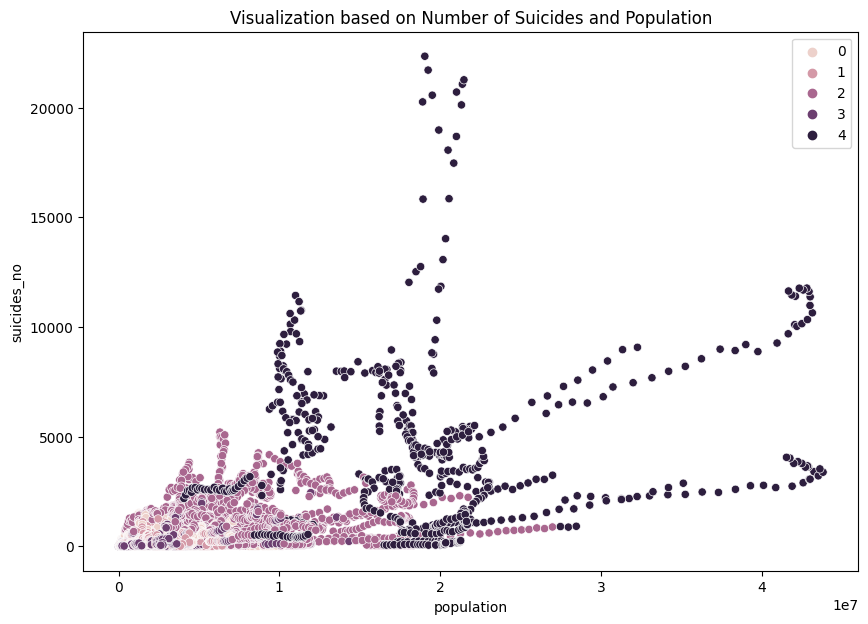

In [79]:
plt.figure(figsize=(10,7))
sns.scatterplot(data=pandas_df, x="population", y="suicides_no", hue="cluster")
plt.title('Visualization based on Number of Suicides and Population')
plt.xlabel('Number of Suicides')
plt.ylabel('Population')
plt.legend()
plt.show()

In [80]:
del pandas_df

### Cluster Visualization based on th Country-Year and Number of Suicides

In [81]:
pandas_df = df.select('country-year', 'suicides_no').toPandas()
pandas_df

,country-year,suicides_no
0,Albania1987,21
1,Albania1987,16
2,Albania1987,14
3,Albania1987,1
4,Albania1987,9
...,...,...
27815,Uzbekistan2014,107
27816,Uzbekistan2014,9
27817,Uzbekistan2014,60
27818,Uzbekistan2014,44


In [82]:
pandas_df['cluster'] = df_pca.select('cluster').toPandas()
pandas_df

,country-year,suicides_no,cluster
0,Albania1987,21,0
1,Albania1987,16,0
2,Albania1987,14,0
3,Albania1987,1,0
4,Albania1987,9,0
...,...,...,...
27815,Uzbekistan2014,107,3
27816,Uzbekistan2014,9,3
27817,Uzbekistan2014,60,3
27818,Uzbekistan2014,44,3


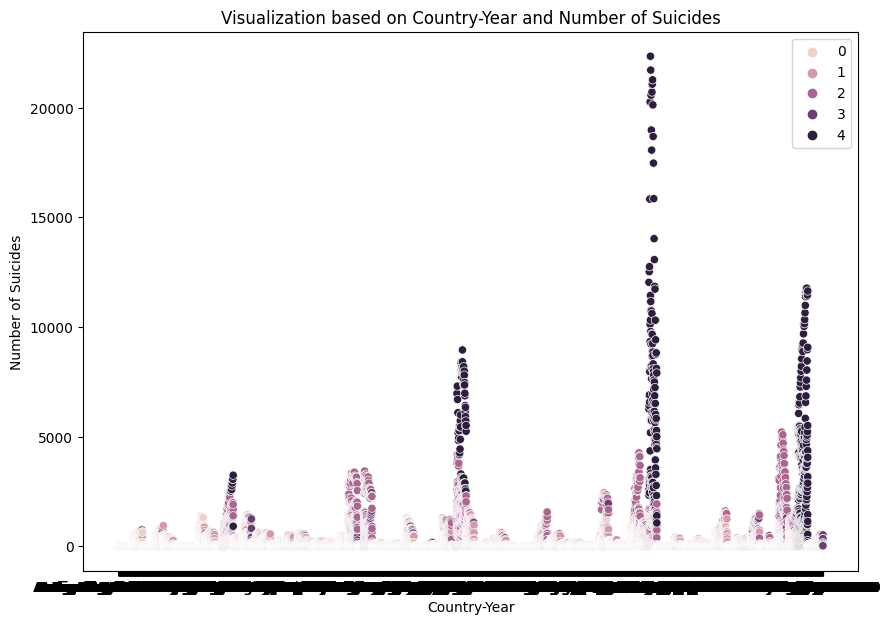

In [87]:
plt.figure(figsize=(10,7))
sns.scatterplot(data=pandas_df, x="country-year", y="suicides_no", hue="cluster")
plt.title('Visualization based on Country-Year and Number of Suicides')
plt.xlabel('Country-Year')
plt.ylabel('Number of Suicides')
plt.legend()
plt.show()

In [88]:
del pandas_df

### Cluster Visualization based on PCA 1 and 2 Representation

In [51]:
pandas_df_pca = df_pca.toPandas()

In [52]:
pandas_df_pca['pca_1'] = pandas_df_pca['pca'].apply(lambda x: x[0])
pandas_df_pca['pca_2'] = pandas_df_pca['pca'].apply(lambda x: x[1])
pandas_df_pca = pandas_df_pca.drop(columns=['pca'])
pandas_df_pca

,cluster,pca_1,pca_2
0,0,0.688740,-1.500127
1,0,0.791144,-1.416024
2,0,0.797833,-1.482608
3,0,0.833343,-2.156447
4,0,0.617555,-1.540199
...,...,...,...
27815,3,0.622884,4.398311
27816,3,1.169936,4.395999
27817,3,0.751440,4.396928
27818,3,0.868770,4.408116


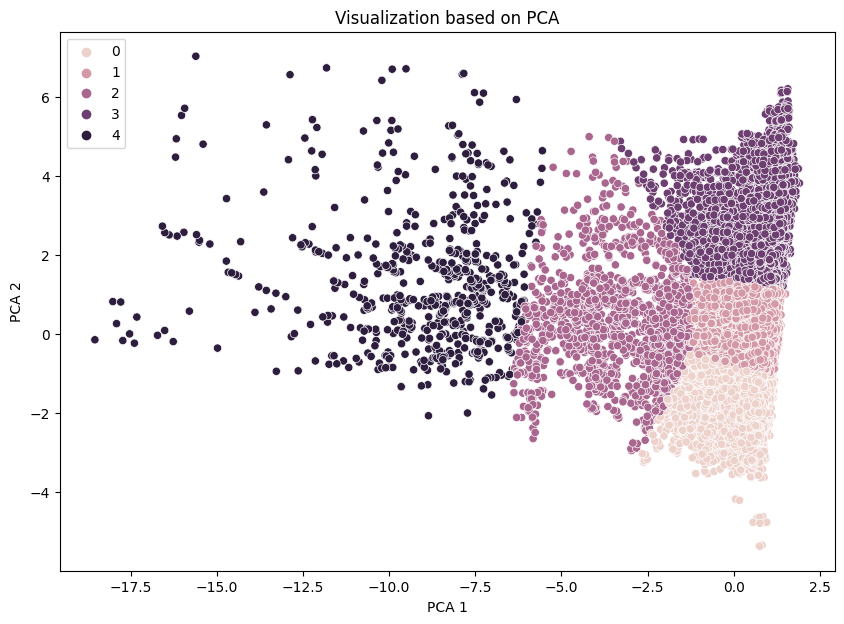

In [58]:
plt.figure(figsize=(10,7))
sns.scatterplot(data=pandas_df_pca, x="pca_1", y="pca_2", hue="cluster")
plt.title('Visualization based on PCA')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()

In [59]:
del pandas_df_pca

# Summary

The optimal clusters for the dataset are 5 clusters. Visualization based on dataset feature doesn't always give a really nice results.<br><br>

For example the visualizataion based on Number of Suicides and Population yielde a bad results while the visualization based on Country-Year and Number of Suicides yielded in a good enough result. <br><br>

The best visualization hovewer can be represented with dimension reduction using PCA dan that can represent all of the vector that was used when training the model. That's the reason why visualization with PCA yielded the most clear and good result